In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
sys.path.insert(1,"..")
import tarfile
import tensorflow as tf
import zipfile
import pathlib
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [2]:
while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')

In [3]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  model_fn = model.signatures['serving_default']
  output_dict = model_fn(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

In [4]:
def show_inference(model, image_path):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = np.array(Image.open(image_path))


  # Actual detection.
    
  output_dict = run_inference_for_single_image(model, image_np)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)

  display(Image.fromarray(image_np))

In [5]:
#Code permettant d'utiliser le model réentraîner
PATH_TO_LABELS = './annotations/label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
model = tf.saved_model.load("./exported-models/my_model/saved_model")
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('./test_images')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))

2022-02-25 23:16:28.711006: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-25 23:16:28.735649: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/noetic/lib
2022-02-25 23:16:28.735663: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-02-25 23:16:28.736262: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneA

test_images/1478019974679051391_jpg.rf.7XNGCef6norKALU4vpMn.jpg


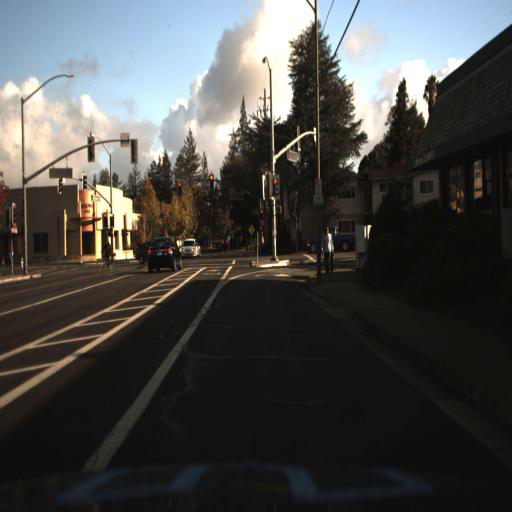

test_images/1478019975180844551_jpg.rf.067fd6f8346d62a38da50548d06554f6.jpg


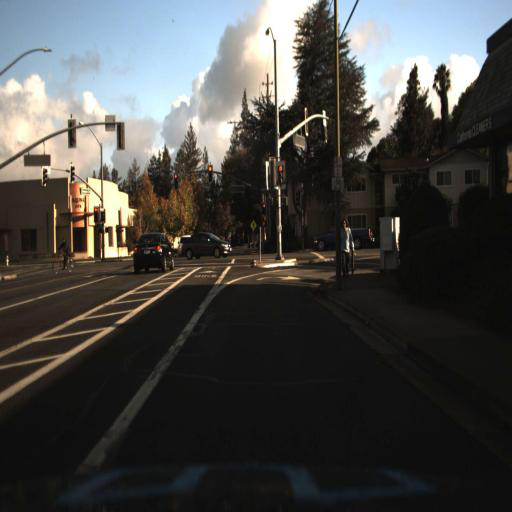

test_images/1478019975180844551_jpg.rf.oohKfembSduZoxzk4zDw.jpg


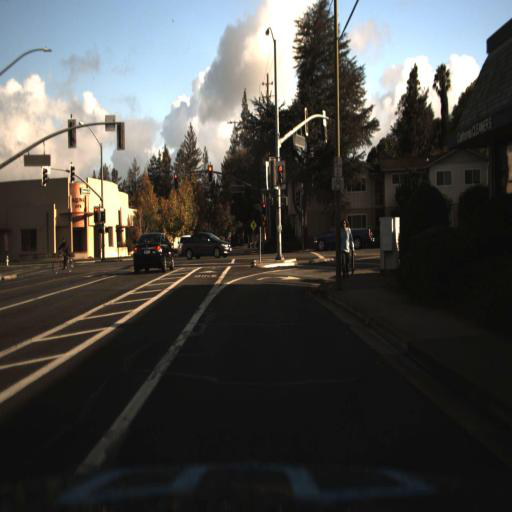

test_images/1478019975685727611_jpg.rf.6c5fc5c2d37cd11484ca1631067c0e23.jpg


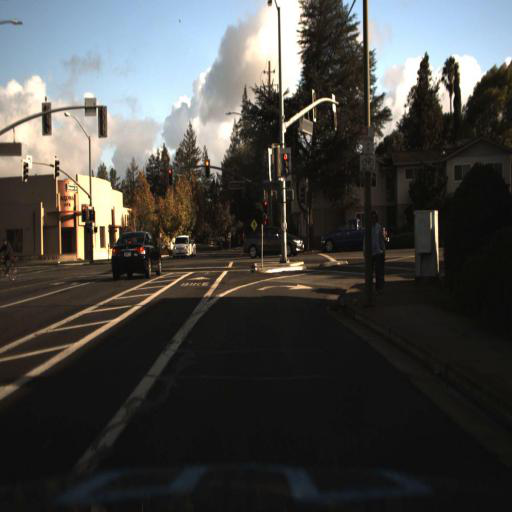

test_images/1478019975685727611_jpg.rf.NXfikkf0vjuRywMeqAf6.jpg


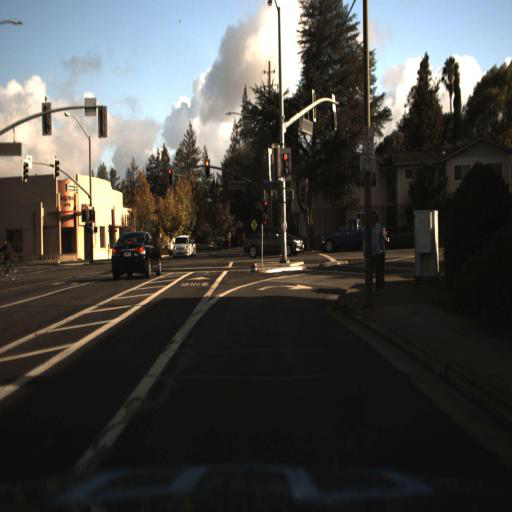

test_images/1478019976185898081_jpg.rf.2wrKWPc6YpsT6cf3cIbc.jpg


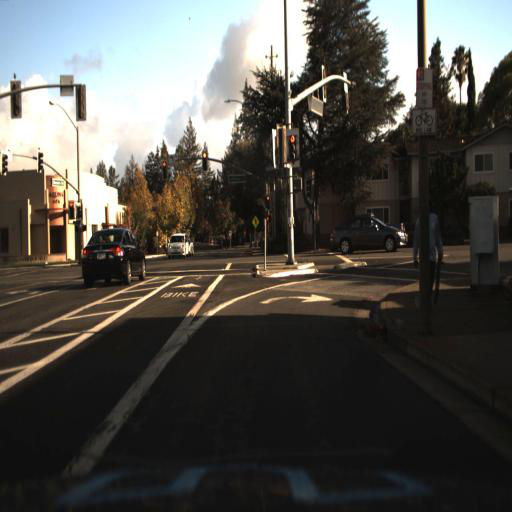

In [6]:
for image_path in TEST_IMAGE_PATHS:
    print(image_path)
    show_inference(model, image_path)

Le modèle réentraîné ne détecte rien du tout ni les voitures ni les piétons. 
Le modèle ne détecte rien car il a été entraîner sur seulement 10 000 itérations ce qui ma pris une journée entière. Les modèles pré-entraîner sont entraînés avec 250 000 itérations. 
Il m'était impossible avec le temps disponible d'entraîner un modèle sur 250 000 itérations et d'avoir de bons résultats.